In [39]:
# This notebook contains experiments that are meant to show a progression of ensembling methods
# in simple settings to progressively more complex settings.
# I only focus on problems with categorical targets, and compare how they perform to comprable continuous targets.

In [40]:
from collections import defaultdict
import time
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

from phd.feature_search.core.models import LTU, MultipleLinear, ParallelLinear
from phd.feature_search.core.idbd import IDBD

%matplotlib inline

## 1-Layer categorical classification experiment

In this experiment, we prepare a 1-layer target network that produces categorical targets. \
An ensemble learning model is created, where each ensemble member recieves a fixed number of the real input and distractors. \
Which of the real inputs each ensemble member recieves differs between members, so each member should learn to make partially differing predictions. \
The goal is to see if the accuracy approaches 100% as the number of ensemble members increases, and if more members increases sample efficiency.

In [ ]:
def run_1l_classification_experiment(
    n_train_samples: int,
    n_inputs: int,
    n_members: int,
    frac_real_inputs: float,
    n_target_bins: int,
    step_size: float = 0.01,
    noise_std: float = 0.0,
    device: str = 'cpu',
    seed: Optional[int] = None,
):
    seed = int(time.time() * 1000) if seed is None else seed
    torch.manual_seed(seed)

    # Generate random weights for the input features
    target_model = nn.Linear(n_inputs, n_target_bins, device=device)
    
    # Generate random weights for the ensemble using ParallelLinear
    # Output should be categorical logits for each bin
    ensemble_model = MultipleLinear( # ParallelLinear(
        in_features = n_inputs,
        out_features = n_target_bins,
        n_parallel = n_members,
        bias = True,
        generator = torch.Generator().manual_seed(seed + 1)
    ).to(device)
    
    # Create an RMSProp optimizer for the ensemble
    optimizer = optim.RMSprop(ensemble_model.parameters(), lr=step_size)
    
    # Generate a set of input samples
    inputs = torch.randn(n_train_samples, n_inputs, device=device)
    distractor_mask = torch.zeros(n_members, n_inputs)
    n_distractors = int(n_inputs * (1 - frac_real_inputs))
    for i in range(n_members):
        distractor_idxs = torch.randperm(n_inputs)[:n_distractors]
        distractor_mask[i, distractor_idxs] = 1.0
    distractor_mask = distractor_mask.to(device)
    
    # Generate targets for each input sample with a pass through the target model using a normal distribution
    with torch.no_grad():
        target_logits = target_model(inputs)  # Shape: (n_train_samples, n_target_bins)
        # Add some noise to make it more realistic
        noise = torch.randn_like(target_logits) * noise_std
        target_logits = target_logits + noise
        target_probs = F.softmax(target_logits, dim=-1)
        target_labels = torch.argmax(target_probs, dim=-1)
    
    # Create a dict of lists to store metrics
    metrics = {
        'mean_ensemble_loss': [],
        'accuracy': [],
        'prediction_entropy': [],
    }
    
    # For each sample:
    for i in range(n_train_samples):
        # Get the step's input and output
        input_sample = inputs[i:i+1]  # Shape: (1, n_inputs)
        # batch_target_probs = target_probs[i:i+1]  # Shape: (1,)
        batch_target_labels = target_labels[i:i+1]  # Shape: (1,)
        
        # Insert distractors into the input sample
        random_vals = torch.randn(1, n_members, n_inputs, device=device)
        # (1, n_members, n_inputs)
        input_sample = input_sample.expand(1, n_members, n_inputs) * (1 - distractor_mask) \
            + random_vals * distractor_mask.unsqueeze(0)
        
        # Forward pass through ensemble
        ensemble_logits = ensemble_model(input_sample).squeeze(0)  # Shape: (n_members, n_target_bins)
        # print(input_sample.shape, ensemble_logits.shape, target_labels.expand(n_members).shape)
        member_loss = F.cross_entropy(ensemble_logits, batch_target_labels.expand(n_members), reduction='sum')
        
        # Calculate ensemble predictions for majority voting
        # Get predictions from each member and collate with majority vote
        member_predictions = torch.argmax(ensemble_logits, dim=1)  # Shape: (n_members)
        voted_prediction = torch.mode(member_predictions).values  # Shape: (,)
        
        # Train on the one step with RMSProp
        optimizer.zero_grad()
        member_loss.backward()
        optimizer.step()
        
        # Log the loss and the loss when converting the prediction back to a continuous variable
        with torch.no_grad():
            # Calculate accuracy for categorical prediction using majority vote
            cat_accuracy = (voted_prediction == batch_target_labels.squeeze()).float().mean().item()
            
            # Calculate entropy of member predictions
            pred_counts = torch.bincount(member_predictions, minlength=n_target_bins)
            pred_probs = pred_counts.float() / n_members
            entropy = -torch.sum(pred_probs * torch.log(pred_probs + 1e-10)).item()
            
            metrics['mean_ensemble_loss'].append(member_loss.item() / n_members)
            metrics['accuracy'].append(cat_accuracy)
            metrics['prediction_entropy'].append(entropy)
    
    # Return a tuple that contains the ensemble model, target model, loss, and dict of metrics
    return ensemble_model, target_model, metrics

### Ensemble member comparison

In [101]:
learning_model_single, target_model_single, metrics_single = run_1l_classification_experiment(
    n_train_samples = 10000,
    n_inputs = 50,
    n_members = 1,
    frac_real_inputs = 0.6,
    n_target_bins = 20,
    step_size = 0.01,
    noise_std = 0.0,
    device = 'cpu',
    seed = 20250808,
)

learning_model_ensemble, target_model_ensemble, metrics_10 = run_1l_classification_experiment(
    n_train_samples = 10000,
    n_inputs = 50,
    n_members = 10,
    frac_real_inputs = 0.6,
    n_target_bins = 20,
    step_size = 0.01,
    noise_std = 0.0,
    device = 'cpu',
    seed = 20250808,
)

learning_model_ensemble, target_model_ensemble, metrics_50 = run_1l_classification_experiment(
    n_train_samples = 10000,
    n_inputs = 50,
    n_members = 50,
    frac_real_inputs = 0.6,
    n_target_bins = 20,
    step_size = 0.01,
    noise_std = 0.0,
    device = 'cpu',
    seed = 20250808,
)

learning_model_ensemble, target_model_ensemble, metrics_200 = run_1l_classification_experiment(
    n_train_samples = 10000,
    n_inputs = 50,
    n_members = 200,
    frac_real_inputs = 0.6,
    n_target_bins = 20,
    step_size = 0.01,
    noise_std = 0.0,
    device = 'cpu',
    seed = 20250808,
)

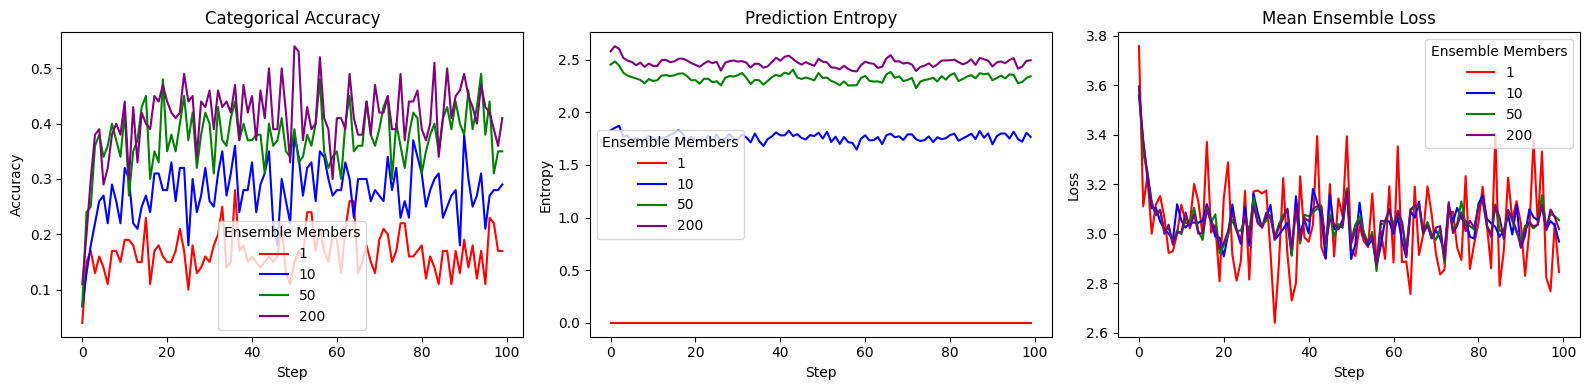

In [102]:
def plot_metrics_comparison(metrics_list, n_members_list, bin_size=50):
    """Plot comparison of metrics across different ensemble sizes.
    
    Args:
        metrics_list: List of metrics dictionaries from experiments
        n_members_list: List of number of ensemble members corresponding to metrics
        bin_size: Size of bins for smoothing plots
    """
    # Set up colors for different ensemble sizes
    colors = ['red', 'blue', 'green', 'purple', 'orange']
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
    
    for metrics, n_members, color in zip(metrics_list, n_members_list, colors):
        # Process metrics
        acc_array = np.array(metrics['accuracy'])
        n_bins = len(acc_array) // bin_size
        acc_binned = acc_array[:n_bins*bin_size].reshape(-1, bin_size).mean(axis=1)

        ent_array = np.array(metrics['prediction_entropy'])
        ent_binned = ent_array[:n_bins*bin_size].reshape(-1, bin_size).mean(axis=1)

        loss_array = np.array(metrics['mean_ensemble_loss'])
        loss_binned = loss_array[:n_bins*bin_size].reshape(-1, bin_size).mean(axis=1)
        
        # Plot metrics
        sns.lineplot(data=acc_binned, ax=ax1, color=color, label=str(n_members))
        sns.lineplot(data=ent_binned, ax=ax2, color=color, label=str(n_members))
        sns.lineplot(data=loss_binned, ax=ax3, color=color, label=str(n_members))
    
    # Configure axes
    ax1.set_title('Categorical Accuracy')
    ax1.set_xlabel('Step')
    ax1.set_ylabel('Accuracy')
    ax1.legend(title='Ensemble Members')

    ax2.set_title('Prediction Entropy')
    ax2.set_xlabel('Step')
    ax2.set_ylabel('Entropy')
    ax2.legend(title='Ensemble Members')

    ax3.set_title('Mean Ensemble Loss')
    ax3.set_xlabel('Step')
    ax3.set_ylabel('Loss')
    ax3.legend(title='Ensemble Members')

    plt.tight_layout()

# Plot metrics for different ensemble sizes
plot_metrics_comparison(
    metrics_list = [metrics_single, metrics_10, metrics_50, metrics_200],
    n_members_list = [1, 10, 50, 200],
    bin_size = 100,
)

In [ ]:
# Question: why do the benefits stop helping after not that many members?
# Is it related to how I make feature vectors with features either perfectly correct or not at all correct?

# TODO:
# - [ ] Ablations on percent of correct features
# - [ ] Ablations on noisy targets
# - [ ] Ablations on prediction combination methods, voting vs. probability cumulation
